In [1]:
using Pkg
# Pkg.add("Profile")
# Pkg.instantiate()

In [2]:
#= dependencies = ["DelimitedFiles", "LinearAlgebra", "Optim", "Distributions", "Test",
                "BenchmarkTools", "Random", "CSV", "DataFrames", "Distributed", "Plots"];
Pkg.add(dependencies)=#

In [3]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Distributed
using Plots
using Profile

In [4]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM.jl/analysis"

In [5]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");
include("../src/scan_for_tests.jl")

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

In [6]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [7]:
nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

In [8]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

## Do the same for many traits (first 1000):

In [9]:
# Function that extracts the row maximums for a matrix:
function getMaxLod_manyTraits(pheno::Array{Float64, 2}, geno::Array{Float64, 2}, kinship::Array{Float64, 2};
                              ntraits::Int64 = 1000, nperms::Int64 = 1024, original::Bool = true)
    
    if original
        nrows = nperms+1
    else
        nrows = nperms
    end
    
    maxLods_manyTraits = Matrix{Float64}(undef, nrows, ntraits);
    
    for k in 1:ntraits
        
        pheno_k = reshape(pheno[:, k], :, 1);
        results = scan_perms(pheno_k, geno, kinship; nperms = nperms)
        
        maxLods_manyTraits[:, k] = getMaxLod(results)
    end
    
    return maxLods_manyTraits; 
end

function getMaxLod_manyTraits2(pheno::Array{Float64, 2}, geno::Array{Float64, 2}, kinship::Array{Float64, 2};
                              ntraits::Int64 = 1000, nperms::Int64 = 1024, original::Bool = true)
    
    if original
        nrows = nperms+1
    else
        nrows = nperms
    end
    
    maxLods_manyTraits = Matrix{Float64}(undef, nrows, ntraits);
    
    for k in 1:ntraits
        
        pheno_k = reshape(pheno[:, k], :, 1);
        results = scan_perms2(pheno_k, geno, kinship; nperms = nperms)
        
        maxLods_manyTraits[:, k] = getMaxLod(results)
    end
    
    return maxLods_manyTraits; 
end


function getMaxLod(results::Array{Float64, 2})
    
    return mapslices(x -> maximum(x), results; dims = 2);
    
end

getMaxLod (generic function with 1 method)

In [10]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 1024);

  7.435 s (215713 allocations: 13.63 GiB)


In [11]:
@btime scan_perms2(pheno_y, geno, kinship; nperms = 1024);

  7.538 s (117063 allocations: 13.62 GiB)


In [12]:
@benchmark scan_perms(pheno_y, geno, kinship; nperms = 500) samples = 5 # old way of doing it (in scan.jl)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.553 s …   3.657 s  ┊ GC (min … max): 11.63% … 11.71%
 Time  (median):     3.605 s              ┊ GC (median):    11.67%
 Time  (mean ± σ):   3.605 s ± 73.445 ms  ┊ GC (mean ± σ):  11.67% ±  0.06%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.55 s         Histogram: frequency by time        3.66 s <

 Memory estimate: 6.68 GiB, allocs estimate: 208931.

In [13]:
@benchmark scan_perms2(pheno_y, geno, kinship; nperms = 500) samples = 5 # new way of doing it (in scan_for_tests.jl)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.591 s …   3.615 s  ┊ GC (min … max): 13.35% … 13.06%
 Time  (median):     3.603 s              ┊ GC (median):    13.21%
 Time  (mean ± σ):   3.603 s ± 16.912 ms  ┊ GC (mean ± σ):  13.21% ±  0.20%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.59 s         Histogram: frequency by time        3.61 s <

 Memory estimate: 6.67 GiB, allocs estimate: 116539.

In [14]:
ntraits_list = [1, 10, 20, 30, 80, 100];
nperms_list = [0, 10, 20, 40, 80, 100];

runtimes_list1 = Array{Float64, 2}(undef, length(ntraits_list), length(nperms_list));
memorys_list1 = Array{Float64, 2}(undef, length(ntraits_list), length(nperms_list));
runtimes_list2 = Array{Float64, 2}(undef, length(ntraits_list), length(nperms_list));
memorys_list2 = Array{Float64, 2}(undef, length(ntraits_list), length(nperms_list));

In [15]:
for i in 1:length(ntraits_list)
    
    ntraits = ntraits_list[i];
    
    for j in 1:length(nperms_list)
        
        nperms = nperms_list[j];
        
        b1 = @benchmark getMaxLod_manyTraits(pheno, geno, kinship; ntraits = $ntraits, nperms = $nperms);
        b1 = median(b1);
        
        b2 = @benchmark getMaxLod_manyTraits2(pheno, geno, kinship; ntraits = $ntraits, nperms = $nperms);
        b2 = median(b2);
        
        runtimes_list1[i, j] = time(b1)/1e9;
        memorys_list1[i, j] = memory(b1)/(1024*1024*1024);
        
        runtimes_list2[i, j] = time(b2)/1e9;
        memorys_list2[i, j] = memory(b2)/(1024*1024*1024);
    
    end
end

In [16]:
runtimes_list1 # row: number of traits; column: number of permutations

6×6 Matrix{Float64}:
 0.0376895   0.104443   0.15738   0.230437   0.744745   0.853291
 0.368006    1.08533    1.58594   2.49179    6.99951    8.34851
 0.888596    2.16949    3.13422   4.73391   14.2115    17.2561
 1.32804     3.34587    4.8198    7.82239   22.0806    25.718
 3.84106     9.94278   13.8035   22.3972    58.3677    69.0123
 4.96334    13.4909    16.762    28.8554    72.4232    89.2696

In [17]:
runtimes_list2 # row: number of traits; column: number of permutations

6×6 Matrix{Float64}:
 0.0170308   0.0747063   0.122727   0.193464   0.633729   0.754319
 0.196867    0.778894    1.2081     1.88145    6.19146    7.34724
 0.438718    1.59272     2.43239    3.79474   12.5398    15.0772
 0.736098    2.58575     4.23686    6.35309   19.0546    22.5773
 2.10505     7.47278    11.4502    19.8104    51.1559    61.4696
 2.77425    10.5684     14.6061    26.4162    64.0336    77.5121

In [18]:
memorys_list1 # row: number of traits; column: number of permutations

6×6 Matrix{Float64}:
 0.0494577   0.183009   0.315906   0.580501    1.10969    1.37548
 0.494594    1.83011    3.15908    5.80502    11.0969    13.7548
 0.989179    3.66021    6.31815   11.61       22.1938    27.5097
 1.48378     5.49033    9.47725   17.4151     33.2907    41.2645
 3.95671    14.6408    25.2726    46.4401     88.7752   110.039
 4.94424    18.2994    31.5891    58.0485    110.967    137.547

In [19]:
memorys_list2 # row: number of traits; column: number of permutations

6×6 Matrix{Float64}:
 0.0407284   0.174271   0.307159   0.571299    1.10089    1.36666
 0.407302    1.74273    3.07161    5.71301    11.0089    13.6667
 0.814594    3.48545    6.14321   11.426      22.0178    27.3333
 1.2219      5.22819    9.21483   17.139      33.0267    41.0
 3.25837    13.9418    24.5728    45.704      88.0711   109.333
 4.07131    17.4256    30.7144    57.1284    110.087    136.665

In [20]:
labels = map(x -> string("nperms = ", x), string.(nperms_list))

6-element Vector{String}:
 "nperms = 0"
 "nperms = 10"
 "nperms = 20"
 "nperms = 40"
 "nperms = 80"
 "nperms = 100"

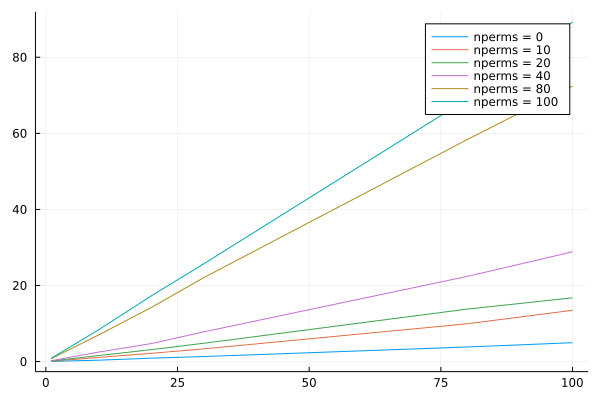

In [21]:
labels = map(x -> string("nperms = ", x), string.(nperms_list))
plot(ntraits_list, runtimes_list1, label = permutedims(labels), lw = 1)

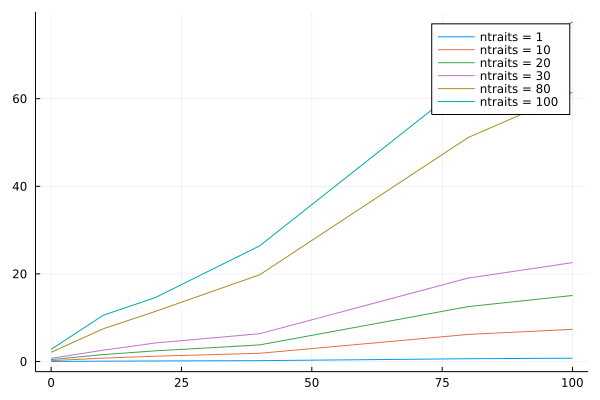

In [22]:
labels = map(x -> string("ntraits = ", x), string.(ntraits_list))
plot(nperms_list, permutedims(runtimes_list2), labels = permutedims(labels), lw = 1)

In [70]:
@benchmark scan_perms(pheno_y, geno, kinship)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 7.955 s (15.69% GC) to evaluate,
 with a memory estimate of 13.63 GiB, over 215712 allocations.

In [71]:
@benchmark scan_perms2(pheno_y, geno, kinship)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 7.369 s (18.22% GC) to evaluate,
 with a memory estimate of 13.62 GiB, over 117063 allocations.

In [72]:
@benchmark scan_perms_toCompare(pheno_y, geno, kinship)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 13.491 s (13.59% GC) to evaluate,
 with a memory estimate of 20.52 GiB, over 79258607 allocations.

In [75]:
seeds_list = collect(1:10)

10-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [78]:
(y_st_perms, X_st) = map(x -> permuteHelper(pheno_y, geno, kinship; nperms = 100, rndseed = x), seeds_list); # create 1024 copies of y_star

In [81]:
size(y_st_perms)

LoadError: MethodError: no method matching size(::Tuple{Matrix{Float64}, Matrix{Float64}})
[0mClosest candidates are:
[0m  size(::Tuple, [91m::Integer[39m) at tuple.jl:27
[0m  size([91m::Union{QR, LinearAlgebra.QRCompactWY, QRPivoted}[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:558
[0m  size([91m::Union{QR, LinearAlgebra.QRCompactWY, QRPivoted}[39m, [91m::Integer[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:557
[0m  ...